In [1]:
# basically learning how to inverse transform to signal

# iPython specific stuff
%matplotlib inline
import IPython.display
from ipywidgets import interact, interactive, fixed

# Packages we're using
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.io import wavfile
from scipy.signal import butter, lfilter
import scipy.ndimage
import soundfile as sf


In [12]:

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def overlap(X, window_size, window_step):
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!")
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))

    ws = window_size
    ss = window_step
    a = X

    valid = len(a) - ws
    nw = (valid) // ss
    out = np.ndarray((nw, ws), dtype=a.dtype)

    for i in range(nw):
        # "slide" the window along the samples
        start = i * ss
        stop = start + ws
        out[i] = a[start: stop]

    return out


def stft(X, fftsize=128, step=65, mean_normalize=True, real=False,
         compute_onesided=True):
    """
    Compute STFT for 1D real valued input X
    """
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()

    X = overlap(X, fftsize, step)

    size = fftsize
    win = 1 #0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    # X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X


def pretty_spectrogram(d, log=True, thresh=5, fft_size=512, step_size=64):
    """
    creates a spectrogram
    log: take the log of the spectrgram
    thresh: threshold minimum power for log spectrogram
    """
    specgram = np.abs(stft(d, fftsize=fft_size, step=step_size, real=False,
                           compute_onesided=True))

    if log == True:
        specgram /= specgram.max()  # volume normalize to max 1
        specgram = np.log10(specgram)  # take log
        specgram[specgram < -thresh] = -thresh  # set anything less than the threshold as the threshold
    else:
        specgram[specgram < thresh] = thresh  # set anything less than the threshold as the threshold

    return specgram


def invert_pretty_spectrogram(X_s, log=True, fft_size=512, step_size=512 / 4, n_iter=10):
    if log == True:
        X_s = np.power(10, X_s)

    X_s = np.concatenate([X_s, X_s[:, ::-1]], axis=1)
    X_t = iterate_invert_spectrogram(X_s, fft_size, step_size, n_iter=n_iter)
    return X_t


def iterate_invert_spectrogram(X_s, fftsize, step, n_iter=10, verbose=False):
    reg = np.max(X_s) / 1E8
    X_best = copy.deepcopy(X_s)
    for i in range(n_iter):
        if verbose:
            print("Runnning iter %i" % i)
        if i == 0:
            X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                                     set_zero_phase=True)
        else:
            # Calculate offset was False in the MATLAB version
            # but in mine it massively improves the result
            # Possible bug in my impl?
            X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                                     set_zero_phase=False)
        est = stft(X_t, fftsize=fftsize, step=step, compute_onesided=False)
        phase = est / np.maximum(reg, np.abs(est))
        X_best = X_s * phase[:len(X_s)]
    X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                             set_zero_phase=False)
    return np.real(X_t)


def invert_spectrogram(X_s, step, calculate_offset=True, set_zero_phase=True):
    size = int(X_s.shape[1] // 2)
    wave = np.zeros((X_s.shape[0] * step + size))
    # Getting overflow warnings with 32 bit...
    wave = wave.astype('float64')
    total_windowing_sum = np.zeros((X_s.shape[0] * step + size))
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))

    est_start = int(size // 2) - 1
    est_end = est_start + size
    for i in range(X_s.shape[0]):
        wave_start = int(step * i)
        wave_end = wave_start + size
        if set_zero_phase:
            spectral_slice = X_s[i].real + 0j
        else:
            # already complex
            spectral_slice = X_s[i]

        # Don't need fftshift due to different impl.
        wave_est = np.real(np.fft.ifft(spectral_slice))[::-1]
        if calculate_offset and i > 0:
            offset_size = size - step
            if offset_size <= 0:
                print("WARNING: Large step size >50\% detected! "
                      "This code works best with high overlap - try "
                      "with 75% or greater")
                offset_size = step
            offset = xcorr_offset(wave[wave_start:wave_start + offset_size],
                                  wave_est[est_start:est_start + offset_size])
        else:
            offset = 0
        #wave[wave_start:wave_end] += win * wave_est[
        #                                   est_start - offset:est_end - offset]
        wave[wave_start:wave_end] += wave_est[
                                           est_start - offset:est_end - offset]
    #    total_windowing_sum[wave_start:wave_end] += win
    #wave = np.real(wave) / (total_windowing_sum + 1E-6)
    return wave

def xcorr_offset(x1, x2):
    x1 = x1 - x1.mean()
    x2 = x2 - x2.mean()
    frame_size = len(x2)
    half = frame_size // 2
    corrs = np.convolve(x1.astype('float32'), x2[::-1].astype('float32'))
    corrs[:half] = -1E30
    corrs[-half:] = -1E30
    offset = corrs.argmax() - len(x1)
    return offset


In [13]:
### Parameters ###
fft_size = 2048 # window size for the FFT
step_size = int(fft_size/1) # distance to slide along the window (in time)
spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
lowcut = 500/3 # Hz # Low cut for our butter bandpass filter
highcut = 15000/3 # Hz # High cut for our butter bandpass filter



# Grab your wav and filter it
data, rate = \
    sf.read('/Users/admin/Desktop/practiceunderpycharm/flac_dataforcnn/10005.flac')
data = data[:16000 * 3]

# try to generate noise
# can add into signal directly
# one thing is important, same size, d.type, and length so can add together

#noise_power = np.var(data) * 4
#noise = np.random.normal(scale=noise_power, size=data.shape)

# define a function to mix
# def mix_with_noise(data, noise):
#     mix = data + noise
#     return mix

#data = data + noise
data = butter_bandpass_filter(data, lowcut, highcut, rate, order=1)


# Only use a short clip for our demo
if np.shape(data)[0]/float(rate) > 10:
    data = data[0:rate*10]
print ('Length in time (s): ', np.shape(data)[0]/float(rate))



Length in time (s):  3.0


In [14]:
# Play the audio
IPython.display.Audio(data=data, rate=rate)



Text(0.5,1.05,'Original Spectrogram')

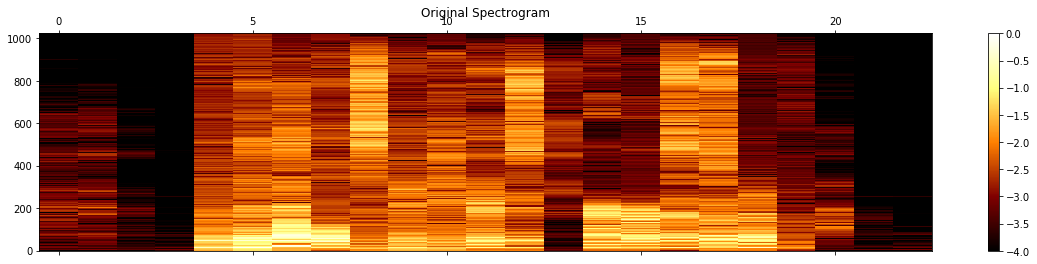

In [15]:
wav_spectrogram = pretty_spectrogram(data.astype('float64'), fft_size = fft_size,
                                   step_size = step_size, log = True, thresh = spec_thresh)

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(wav_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Original Spectrogram')



ValueError: operands could not be broadcast together with shapes (1024,) (257,) (1024,) 

In [22]:
wav_spectrogram.shape

(23, 1024)

In [ ]:
# Make a spectrogram of the inverted audio (for visualization)
inverted_spectrogram = pretty_spectrogram(recovered_audio_orig.astype('float64'), fft_size = fft_size,
                                   step_size = step_size, log = True, thresh = spec_thresh)
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(18,4))
cax = ax.matshow(np.transpose(inverted_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Recovered Spectrogram')

